#  BM20A6100 Advanced Data Analysis and Machine Learning
## Erik Kuitunen, 0537275

### Kernel Principal Component Analysis


Read data, scale and visualize


In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Flowmeters/Meter B", delimiter="	", header=None)
col_names = df.columns.tolist() 

df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,1.185089,1.028128,1.016478,0.1500,2.195744,2.540944,2.511961,2.087889,2.394439,1483.869833,...,49.800000,84.107067,84.003098,120.338783,120.144244,120.371772,120.179078,84.019053,83.919971,1
1,1.191806,1.033750,1.019411,0.2170,2.192467,2.546594,2.516744,2.075706,2.396089,1483.747389,...,49.800000,84.114116,84.009973,120.349089,120.153889,120.381700,120.188800,84.025607,83.927260,1
2,1.181983,1.028089,1.020994,0.0889,3.246672,3.738378,3.715217,3.079356,3.523517,1483.777056,...,49.800000,84.137487,83.983336,120.392450,120.106206,120.425422,120.140578,84.047809,83.901593,1
3,1.182761,1.028783,1.021072,0.1170,3.244489,3.741861,3.718839,3.080400,3.525933,1483.847444,...,49.800000,84.133493,83.979407,120.387033,120.100444,120.419883,120.134933,84.043715,83.897597,1
4,1.182272,1.028922,1.021350,0.0222,3.245944,3.742217,3.715456,3.080950,3.525128,1483.819056,...,49.800000,84.135354,83.980807,120.389361,120.102800,120.422050,120.137472,84.045346,83.898959,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2.418111,0.000000,0.000000,0.0000,5.332300,6.662456,6.288444,0.000000,5.922272,1550.598167,...,96.462778,80.552229,80.323852,118.229294,117.738550,118.007206,117.542750,0.000000,0.000000,3
88,3.290425,0.000000,0.000000,0.0000,5.420572,6.653589,6.309761,0.000000,5.924100,1542.063444,...,96.534444,80.101938,79.872679,118.229300,117.738861,118.005594,117.539489,0.000000,0.000000,3
89,2.601044,0.000000,0.000000,0.0000,5.256956,6.672083,6.287644,0.000000,5.916767,1550.688444,...,96.653889,80.544970,80.321946,118.227667,117.736100,118.002017,117.538133,0.000000,0.000000,3
90,2.336800,0.000000,0.000000,0.0000,5.222706,6.669056,6.288772,0.000000,5.895378,1550.800889,...,96.612778,80.538187,80.317351,118.223733,117.732389,117.997167,117.532778,0.000000,0.000000,3


<Axes: >

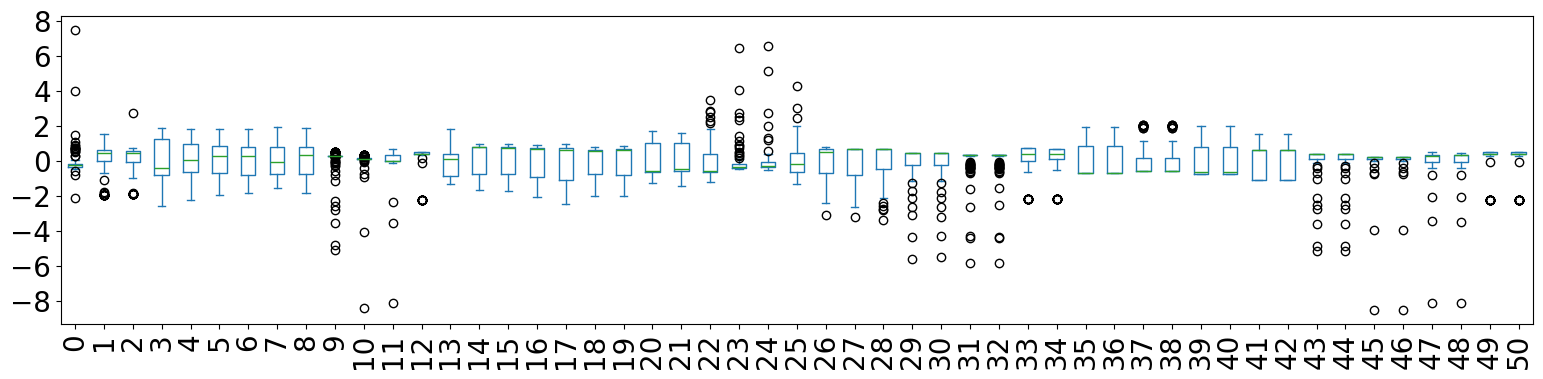

In [202]:
from sklearn.preprocessing import StandardScaler    

XData = df.iloc[ :, :-1 ].values
YData = df.iloc[ :, 1 ].values

scaler = StandardScaler()
scaler.fit( XData )
XData_scaled = scaler.transform( XData )
# YData_scaled = scaler.transform( YData.reshape(-1,1) )

pd.DataFrame( XData_scaled ).plot( kind = 'box', 
                                   figsize = (19,4), 
                                   rot = 90, 
                                   fontsize = 20, 
                                   sharey = False )


Defining kernels

In [203]:
def linear_kernel(X1, X2, sigma = None, degree = None):
    k_xixj = np.dot( X1, X2 )
    return k_xixj

def polynomial_kernel(X1, X2, sigma = None, degree = 2):
    k_xixj = ( np.dot( X1, X2 ) + 1 ) ** degree
    return k_xixj

def gaussian_kernel(X1, X2, sigma = 1, degree = None ):
    k_xixj = np.exp( -np.linalg.norm( X1 - X2 ) ** 2 / ( 2 * sigma ** 2 ) )
    return k_xixj
    

Calculating the Gram matrix using a kernel; centering 

In [204]:
# First using the linear kernel
def gram_centered(  kernel, X, Xhat = None, sigma = None, degree = None ):
    if kernel == 'linear':
        kernel = linear_kernel
    elif kernel == "polynomial":
        kernel = polynomial_kernel
    elif kernel == "gaussian":
        kernel = gaussian_kernel
        
    if Xhat is None:
        Nsamples_i = X.shape[0]
        Nsamples_j = X.shape[0]
        X = X.T
        # Xtest = X
    else:
        X = X.T
        Xhat = Xhat.T
        Nsamples_i = Xhat.shape[1]
        Nsamples_j = X.shape[1]      
        
    # First calculating K for calibration partition
    Kcal = np.zeros( (Nsamples_j, Nsamples_j) )    
    for ii in range(Nsamples_j):
        for jj in range(ii, Nsamples_j):
            elem = kernel( X[ :, ii ], X[ :, jj ], sigma = sigma, degree = degree )
            Kcal[ii, jj] = elem 
            if ii != jj:
                Kcal[jj, ii] = Kcal[ii, jj]
       
    # If fitting the model, return only the centered Gram matrix for calibration set
    if Xhat is None:
        I_n = np.eye( Nsamples_j )
        ones_n = np.ones((Nsamples_j, Nsamples_j))
        multiplier = ( I_n - ones_n / Nsamples_j @ ones_n.T )
        Kcal_hat = multiplier @ Kcal @ multiplier
        return Kcal_hat
    
    
    # If predicting, return the combined centered Gram matrix for calibration and prediction set
    K = np.zeros((Nsamples_i, Nsamples_j))
    for ii in range(Nsamples_i):
        for jj in range(Nsamples_j):
            elem = kernel( Xhat[ :, ii ], X[ :, jj ], sigma = sigma, degree = degree )
            K[ii, jj] = elem 

    ones_n = np.ones( (Nsamples_j, Nsamples_j) ) / Nsamples_j
    ones_ntest = np.ones( (Nsamples_i, Nsamples_j) ) / Nsamples_j
    K = K - ones_ntest @ Kcal - K @ ones_n + ones_ntest @ Kcal @ ones_n
    
    return K

PLS function. No cross-validation, since amont of data is low.

In [233]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler    


def pls_model( X_train, y_train, X_test, y_test, n_comp, kernel = None, sigma = None, degree = None ):
    
    if kernel is None:
        model = PLSRegression( n_components = n_comp ).fit( X_train, y_train )
        y_pred_test = model.predict( X_test )
    else:
        K_train = gram_centered( kernel, X_train, sigma = sigma, degree = degree )
        scaler = StandardScaler().fit( K_train.T )
        
        print( K_train.shape )
        K_train = scaler.transform( K_train )
        print( K_train.shape )
        
        K_test = gram_centered( kernel, X_train, Xhat = X_test, sigma = sigma, degree = degree )
        
        print( K_test.shape )
        K_test = scaler.transform( K_train )
        print( K_test.shape )
        # print( K_train.shape, K_test.shape )
        
        model = PLSRegression( n_components = n_comp ).fit( K_train, y_train )
        
        y_pred_test = model.predict( K_test )

    tss = np.sum( (y_train - np.mean(y_train)) ** 2 )
    press = np.sum( (y_pred_test - y_test) ** 2 )

    q2 = 1 - press / tss
    mse = root_mean_squared_error( y_test, y_pred_test )
    r2 = r2_score( y_test, y_pred_test )

    
    return y_pred_test, q2, r2, mse



Defining plotting function

In [206]:
def plot_results( q2vec, r2vec, mse_vec, Nvariables, kernel ):
    components = np.arange(1, Nvariables+1)
    
    plt.figure(figsize=(13, 4))

    plt.subplot(1, 2, 1)
    plt.plot( components, q2vec, '-', label = 'Q2' )
    plt.plot( components, r2vec, '-', label = 'R2')
    plt.title('Q2 and R2 vs Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('R2')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot( components, mse_vec, marker='o' )
    plt.title( 'MSE vs Number of Components' )
    plt.xlabel( 'Number of Components' )
    plt.ylabel( 'MSE' )
    plt.grid()

    plt.suptitle(f"PLS metrics, kernel: {kernel}", )
    plt.tight_layout()
    plt.show()

Test-train split, performing PLS and visualizing metrics

/home/eki/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:345: UserWarning: y residual is constant at iteration 47
  warnings.warn(f"y residual is constant at iteration {k}")
/home/eki/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:345: UserWarning: y residual is constant at iteration 47
  warnings.warn(f"y residual is constant at iteration {k}")
/home/eki/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:345: UserWarning: y residual is constant at iteration 47
  warnings.warn(f"y residual is constant at iteration {k}")
/home/eki/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:345: UserWarning: y residual is constant at iteration 47
  warnings.warn(f"y residual is constant at iteration {k}")


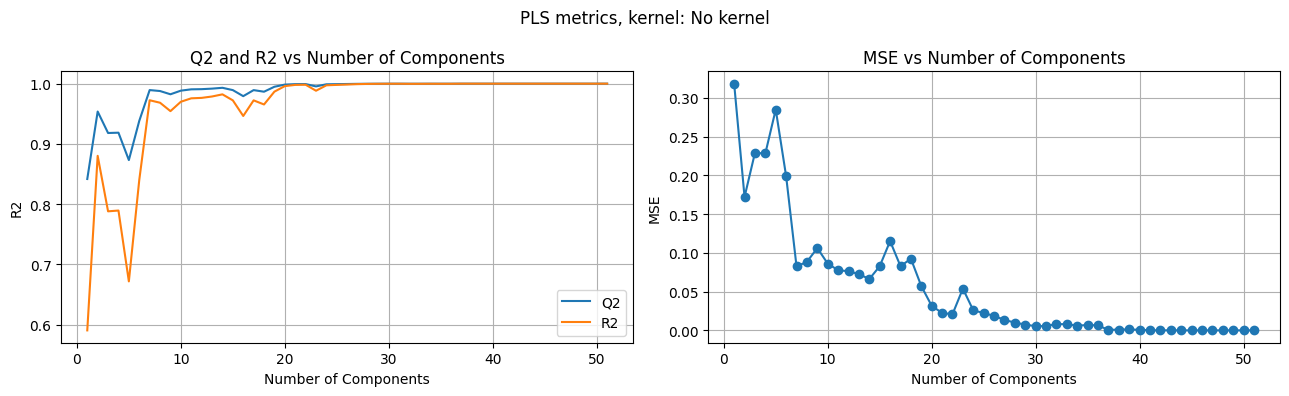

(73, 73)
(73, 73)
(19, 73)
(73, 73)


ValueError: operands could not be broadcast together with shapes (73,) (19,) 

In [234]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( XData, YData, test_size = 0.2 )

Nvariables = XData_scaled.shape[1]

q2vec = np.zeros( Nvariables )
r2vec = np.zeros( Nvariables )
mse_vec = np.zeros( Nvariables )

for ii in range( Nvariables):
    y_pred, q2, r2, mse = pls_model( X_train, y_train, X_test, y_test, ii + 1, kernel = None, sigma = 1 )
    q2vec[ ii ] = q2
    r2vec[ ii ] = r2
    mse_vec[ ii ] = mse
    
plot_results( q2vec, r2vec, mse_vec, Nvariables, "No kernel" )

for ii in range( Nvariables):
    y_pred, q2, r2, mse = pls_model( X_train, y_train, X_test, y_test, ii + 1, kernel = "linear", sigma = 1 )
    q2vec[ ii ] = q2
    r2vec[ ii ] = r2
    mse_vec[ ii ] = mse
    
plot_results( q2vec, r2vec, mse_vec, Nvariables, "Linear" )

for ii in range( Nvariables):
    y_pred, q2, r2, mse = pls_model( X_train, y_train, X_test, y_test, ii + 1, kernel = "gaussian", sigma = 1 )
    q2vec[ ii ] = q2
    r2vec[ ii ] = r2
    mse_vec[ ii ] = mse
    
plot_results( q2vec, r2vec, mse_vec, Nvariables, "Gaussian" )

for ii in range( Nvariables):
    y_pred, q2, r2, mse = pls_model( X_train, y_train, X_test, y_test, ii + 1, kernel = "polynomial", degree = 2 )
    q2vec[ ii ] = q2
    r2vec[ ii ] = r2
    mse_vec[ ii ] = mse
    
plot_results( q2vec, r2vec, mse_vec, Nvariables, "Polynomial" )


